## CS3570 Introduction to Multimedia Technology
### Homework 02 Due: 11:59pm, 4/11/2025

#### In the first part:
You are required to implement DCT compression with different quality factors with the given image file (cat.jpg), and calculate the SSIM score of between the original image and compressed images.

Here's the step:
1. Convert the image from RGB to YCbCr following with chrominance subsampling 4:2:0.
2. Divide the Y, Cb, Cr channels into blocks of 8 x 8 pixels.
3. Shift values by -128 and transform the each 8x8 blocks from spatial domain to the DCT domain.
4. Apply quantization with the provided quantization tables and quality factor.
5. Reconstruct the image by taking inverse discrete cosine transform (IDCT) and shift values by +128.
6. Reassemble the Y, Cb, Cr channels from 8x8 blocks.
7. Upsample Cb, Cr and convert YCbCr back to RGB.
8. Compute the PSNR score with reconstructed images and the original image.

#### In the second part:
You need to design and apply different FIR filters into separate three audio signals from the given audio file (HW2_Mix.wav). Next, you are asked to reduce the sampling rate of filtered signals. Finally, since the output audio signals are too simple, you should apply one-fold echo and multiple-fold echo to produce more complex music.

Here's the step:
1. Transform the input signal into frequency domain and plot the spectrum (magnitude in spectrum should be normalized to [0, 1]).
2. Implement 3 different FIR filters to separate the three audio signals with Blackman window function (You have to pick the appropriate filter size, cut-off frequency, and window size).
3. Implement 1D convolution on the input signal with your filters (zero padding).
4. Reduce the sampling rates of the three separated songs to 2000Hz.
5. Apply one-fold echo and multiple-fold echo on the signal that pass through the **low-pass filter**. (Please use the audio files before reducing sampling rates)

### Reminder:
* **The imported libraries are sufficient for this homework, you are not permitted to import other Python packages.**
* **Your code must display and output your results to enable us to verify its correctness.**
* **Please follow the instructions in the Jupyter Notebook and complete the parts marked as `"TODO."`**
* **Please compress your Jupyter Notebook file, image results from Q1 and audio results from Q2 in a zip file named HW2_xxxxxxxxx_ooo.zip, where xxxxxxxxx is your student ID and ooo is your name.**
* **Homework should be submitted before the announced due time. Scores of late homework will be reduced by 20% per day.**
* **If you encounter any problems or have questions, please post them on eeclass.**

## Part 1: DCT compression (40%)

### Import the necessary libraries

In [63]:
# !pip install opencv-python numpy matplotlib scipy

import numpy as np
from cv2 import imread, imwrite
import matplotlib.pyplot as plt



In [64]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

%cd /content/drive/MyDrive/CloudFiles/2025-Spring/MULT/Homework_02

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CloudFiles/2025-Spring/MULT/Homework_02


### Define the quantization tables

In [65]:
# @title
# Quantization table for Y
QT_L = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 36, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quantization table for Cb, Cr
QT_Chroma = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

### 1. Implement RGB to YCbCr and chrominance subsampling (4:2:0) (5%)

In [66]:
def RGB2YCbCr(img):
    H, W, _ = img.shape
    img_ycbcr = np.zeros(img.shape)
    Y = np.zeros((H, W))
    Cb = np.zeros((H//2, W//2))
    Cr = np.zeros((H//2, W//2))

    # 轉換矩陣
    M = np.array([[0.257, 0.564, 0.098],
                  [-0.148, -0.291, 0.439],
                  [0.439, -0.368, -0.071]])
    C = np.array([16, 128, 128])

    # RGB 轉 YCbCr
    for i in range(H):
        for j in range(W):
            pixel = img[i, j, :].astype(float)
            ycbcr = np.dot(M, pixel) + C
            img_ycbcr[i, j, :] = ycbcr

    # 提取 Y、Cb、Cr 通道並進行 4:2:0 子採樣
    Y = img_ycbcr[:, :, 0]
    Cb_full = img_ycbcr[:, :, 1]
    Cr_full = img_ycbcr[:, :, 2]
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            Cb[i//2, j//2] = Cb_full[i, j]
            Cr[i//2, j//2] = Cr_full[i, j]

    return Y, Cb, Cr

### 2. Implement YCbCr to RGB (5%)

In [67]:
def YCbCr2RGB(Y, Cb, Cr):
    H, W = Y.shape
    # 上採樣 Cb 和 Cr
    Cb_upsample = np.repeat(np.repeat(Cb, 2, axis=0), 2, axis=1)
    Cr_upsample = np.repeat(np.repeat(Cr, 2, axis=0), 2, axis=1)
    img_YCbCr = np.stack((Y, Cb_upsample, Cr_upsample), axis=-1)
    img = np.zeros((H, W, 3))

    # 轉換矩陣
    M = np.array([[1.164, 0, 1.596],
                  [1.164, -0.392, -0.813],
                  [1.164, 2.017, 0]])
    C = np.array([16, 128, 128])

    # YCbCr 轉 RGB
    for i in range(H):
        for j in range(W):
            ycbcr = img_YCbCr[i, j, :] - C
            rgb = np.dot(M, ycbcr)
            img[i, j, :] = np.clip(rgb, 0, 255)

    return img.astype(np.uint8)

### 3. Implement Discrete Cosine Transform (DCT) (5%)

In [68]:
def DCT(f):
    # Get the size of the input block (assuming square N x N)
    N = f.shape[0]
    # Initialize the output frequency domain matrix
    F = np.zeros((N, N))

    # Compute the 2D DCT
    for u in range(N):
        for v in range(N):
            sum_val = 0.0
            for x in range(N):
                for y in range(N):
                    # Compute the cosine terms for the DCT formula
                    cos_x = np.cos((2 * x + 1) * u * np.pi / (2 * N))
                    cos_y = np.cos((2 * y + 1) * v * np.pi / (2 * N))
                    sum_val += f[x, y] * cos_x * cos_y
            # Apply the normalization factors alpha(u) and alpha(v)
            alpha_u = np.sqrt(1 / N) if u == 0 else np.sqrt(2 / N)
            alpha_v = np.sqrt(1 / N) if v == 0 else np.sqrt(2 / N)
            F[u, v] = alpha_u * alpha_v * sum_val

    return F

### 4. Implement Inverse Discrete Cosine Transform (IDCT) (5%)

In [69]:
def IDCT(F):
    # 獲取輸入頻域矩陣的大小（假設是 N x N 的方陣）
    N = F.shape[0]
    # 初始化輸出空間域矩陣
    f = np.zeros((N, N))

    # 計算 2D IDCT
    for x in range(N):
        for y in range(N):
            sum_val = 0.0
            for u in range(N):
                for v in range(N):
                    # 計算餘弦項
                    cos_x = np.cos((2 * x + 1) * u * np.pi / (2 * N))
                    cos_y = np.cos((2 * y + 1) * v * np.pi / (2 * N))
                    # 計算正規化因子 alpha(u) 和 alpha(v)
                    alpha_u = np.sqrt(1 / N) if u == 0 else np.sqrt(2 / N)
                    alpha_v = np.sqrt(1 / N) if v == 0 else np.sqrt(2 / N)
                    # 累加到總和
                    sum_val += alpha_u * alpha_v * F[u, v] * cos_x * cos_y
            f[x, y] = sum_val

    return f

### 5. Implement quantization with quality factor (5%)

In [70]:
def quantize(img, Qf, chroma=True):
    if Qf < 50:
        S = 5000 / Qf
    else:
        S = 200 - 2 * Qf
    if chroma:  # Cb 或 Cr 通道
        QT = QT_Chroma
    else:  # Y 通道
        QT = QT_L
    T_s = np.floor((S * QT + 50) / 100)
    T_s[T_s == 0] = 1  # 避免除以零
    img_quantized = np.round(img / T_s)
    return img_quantized, T_s  # 返回量化後的圖像和量化表

### 6. DCT compression process (10%)

In [71]:
def dct_compression(img, Qf):
    height, width, _ = img.shape  # 注意：這裡應使用 width 而非 weight
    block_size = 8

    Y, Cb, Cr = RGB2YCbCr(img)
    Y_compressed = np.zeros(Y.shape)
    Cb_compressed = np.zeros(Cb.shape)
    Cr_compressed = np.zeros(Cr.shape)

    # 處理 Y 通道
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = Y[i:i+block_size, j:j+block_size]
            if block.shape != (block_size, block_size):
                block = np.pad(block, ((0, block_size - block.shape[0]), (0, block_size - block.shape[1])), 'constant')
            block = block - 128
            dct_block = DCT(block)
            quantized_block, T_s = quantize(dct_block, Qf, chroma=False)
            dequantized_block = quantized_block * T_s
            idct_block = IDCT(dequantized_block) + 128
            Y_compressed[i:i+block_size, j:j+block_size] = idct_block[:min(block_size, height - i), :min(block_size, width - j)]

    # 處理 Cb 通道
    for i in range(0, Cb.shape[0], block_size):
        for j in range(0, Cb.shape[1], block_size):
            block = Cb[i:i+block_size, j:j+block_size]
            if block.shape != (block_size, block_size):
                block = np.pad(block, ((0, block_size - block.shape[0]), (0, block_size - block.shape[1])), 'constant')
            block = block - 128
            dct_block = DCT(block)
            quantized_block, T_s = quantize(dct_block, Qf, chroma=True)
            dequantized_block = quantized_block * T_s
            idct_block = IDCT(dequantized_block) + 128
            Cb_compressed[i:i+block_size, j:j+block_size] = idct_block[:min(block_size, Cb.shape[0] - i), :min(block_size, Cb.shape[1] - j)]

    # 處理 Cr 通道
    for i in range(0, Cr.shape[0], block_size):
        for j in range(0, Cr.shape[1], block_size):
            block = Cr[i:i+block_size, j:j+block_size]
            if block.shape != (block_size, block_size):
                block = np.pad(block, ((0, block_size - block.shape[0]), (0, block_size - block.shape[1])), 'constant')
            block = block - 128
            dct_block = DCT(block)
            quantized_block, T_s = quantize(dct_block, Qf, chroma=True)
            dequantized_block = quantized_block * T_s
            idct_block = IDCT(dequantized_block) + 128
            Cr_compressed[i:i+block_size, j:j+block_size] = idct_block[:min(block_size, Cr.shape[0] - i), :min(block_size, Cr.shape[1] - j)]

    img_compressed = YCbCr2RGB(Y_compressed, Cb_compressed, Cr_compressed)
    return np.clip(img_compressed, 0, 255).astype(np.uint8)

### 7. Implement Peak Signal-to-Noise Ratio (PSNR) (5%)

In [72]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

### Experiment with different quality factor

In [73]:
image = imread('Barbara.jpg')

Qf = 80
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 30
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 5
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

PSNR (Qf=80): 30.53575566256043
PSNR (Qf=30): 30.083131482663795
PSNR (Qf=5): 28.756395537823984


True

## Part 2: FIR Filter (40%)

In [74]:
from scipy.io import wavfile
from scipy.fft import fft, fftfreq

### 1. Plot the frequency spectrum (5%)

In [75]:
def plot_spectrum(data, title, fs, xbond, ybond):
    '''
    Input:
        data: input signal
        title: title of the plot
        fs: sampling frequency
        xbond: x-axis range
        ybond: y-axis range
    '''
    # Compute FFT
    N = len(data)
    freq = fftfreq(N, 1/fs)  # Frequency bins
    spectrum = fft(data)     # FFT of the signal
    magnitude = np.abs(spectrum)  # Normalize magnitude
    magnitude = np.interp(magnitude, (magnitude.min(), magnitude.max()), (0, 1))


    # Take only positive frequencies
    positive_freq = freq[:N//2]
    positive_magnitude = magnitude[:N//2]

    # Plot the magnitude spectrum
    plt.figure()
    plt.plot(positive_freq, positive_magnitude)
    plt.xlim(xbond[0], xbond[1])
    plt.ylim(ybond[0], ybond[1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.show()

### 2. Implement three different filters - Lowpass, Highpass, Bandpass (10%)

In [76]:
def filter_generator(sample_rate, cutoff, filter_type, window_type, N):
    '''
    Input:
        sample_rate: sampling frequency
        cutoff: cutoff frequency (for Lowpass/Highpass) or [low, high] for Bandpass
        filter_type: type of filter ('Lowpass', 'Highpass', 'Bandpass')
        window_type: type of window function ('Blackmann')
        N: filter length (number of points in a filter), also the window length
    Output:
        filter: low-pass, high-pass, or band-pass filter coefficients
    '''
    # Normalize cutoff frequency
    if filter_type == 'Lowpass' or filter_type == 'Highpass':
        cutoff_norm = cutoff / sample_rate
    elif filter_type == 'Bandpass':
        cutoff_norm = [cutoff[0] / sample_rate, cutoff[1] / sample_rate]
    else:
        raise ValueError('Invalid filter type')

    mid = N // 2
    n = np.arange(-mid, mid + 1)  # Time indices centered around zero
    filter = np.zeros(N)

    # Implement the ideal filter
    if filter_type == 'Lowpass':
        # Low-pass filter using sinc function
        filter = np.sinc(2 * cutoff_norm * n) * 2 * cutoff_norm
    elif filter_type == 'Highpass':
        # High-pass filter: invert low-pass and add delta at center
        filter = -np.sinc(2 * cutoff_norm * n) * 2 * cutoff_norm
        filter[mid] += 1  # Add impulse at n=0
    elif filter_type == 'Bandpass':
        # Band-pass filter: difference of two sinc functions
        low = cutoff_norm[0]
        high = cutoff_norm[1]
        filter = (np.sinc(2 * high * n) * 2 * high) - (np.sinc(2 * low * n) * 2 * low)


    # Apply window function
    if window_type == "Blackmann":
        window = np.blackman(N)
        filter *= window  # Element-wise multiplication with Blackman window

    return filter

In [77]:
def plot_filter(filter, title):
    plt.figure()
    plt.plot(filter)
    plt.title(title)
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.show()

### 3. Implement convolution function (10%)

In [78]:
def convolve(signal, filter, N):
    '''
    Input:
        signal: input signal
        filter: filter coefficients
        N: filter length
    Output:
        out: output signal
    '''
    out = np.convolve(signal, filter, mode='same')
    out = out.astype(np.float32)

    return out

### 4. Reduce sample rate (5%)

In [79]:
def down_sampling(signal, fs, new_fs):
    '''
    Input:
        signal: input signal
        fs: sampling frequency
        new_fs: new sampling frequency
    Output:
        output_signal: down-sampled signal
    '''
    # Calculate down-sampling factor
    factor = int(fs / new_fs)
    print("factor, fs, new_fs", factor, fs, new_fs)
    output_signal = signal[::factor]  # Decimate by taking every 'factor'th sample
    return output_signal

### 5. Implement one-fold / multiple-fold echo (10%)

In [80]:
def echo(signal_low, delay, alpha, fs):
    '''
    Input:
        signal_low: input signal (time-domain)
        delay: delay time in seconds
        alpha: attenuation factor
        fs: sampling frequency
    Output:
        output_echo_one: output signal with one-fold echo
        output_echo_multiple: output signal with multiple-fold echo
    '''
    D = int(delay * fs)  # Delay in samples
    input_len = len(signal_low)

    # One-fold echo
    output_echo_one = np.zeros(input_len + D)
    output_echo_one[:input_len] = signal_low  # Original signal
    output_echo_one[D:input_len + D] += alpha * signal_low  # Delayed and attenuated echo

    # Multiple-fold echo
    output_echo_multiple = signal_low.copy()
    current_delay = D
    while current_delay < input_len:
        echo_signal = alpha * output_echo_multiple[:-current_delay]
        output_echo_multiple[current_delay:] += echo_signal
        current_delay += D
    # Trim to original length
    output_echo_multiple = output_echo_multiple[:input_len]

    return output_echo_one.astype(np.float32), output_echo_multiple.astype(np.float32)

### Note: There should be 10 images displayed below the cell.

<ipython-input-81-fe34c552695e>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('HW2_Mix.wav')


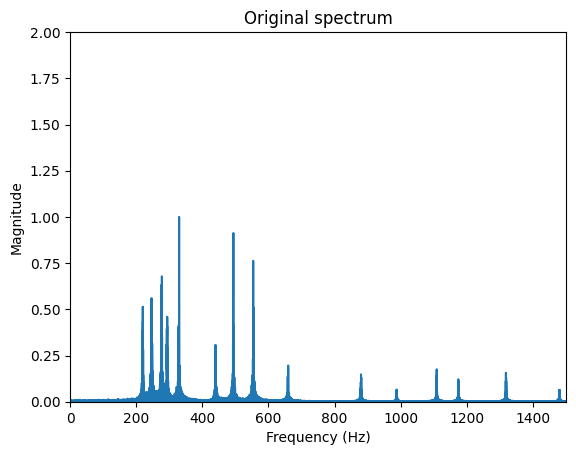

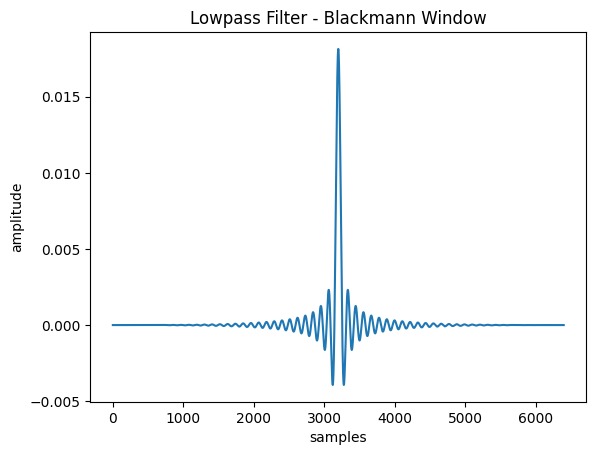

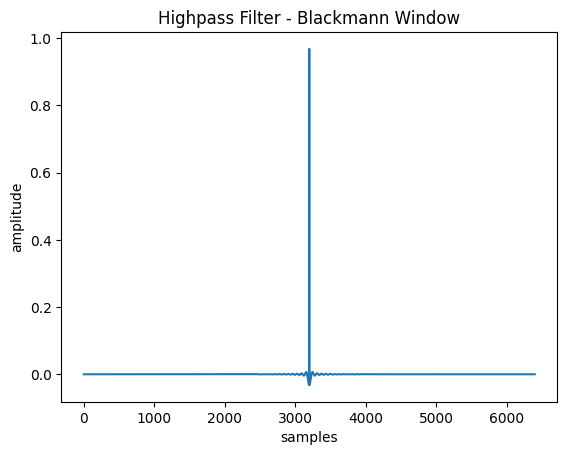

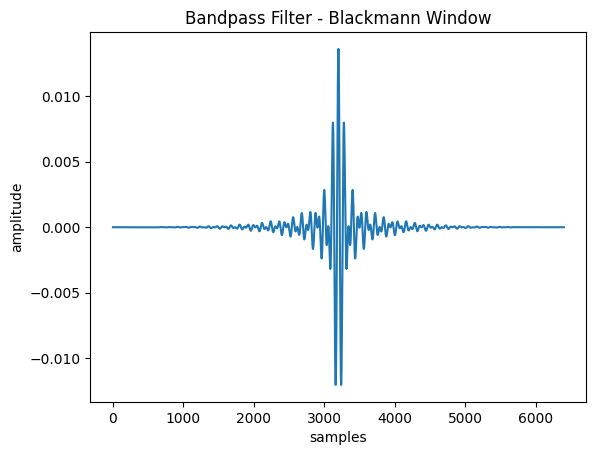

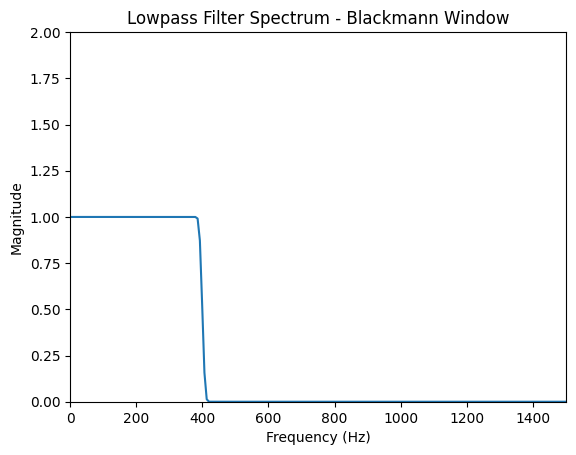

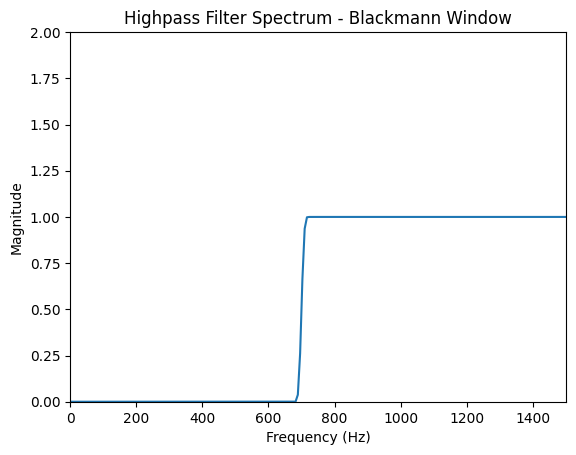

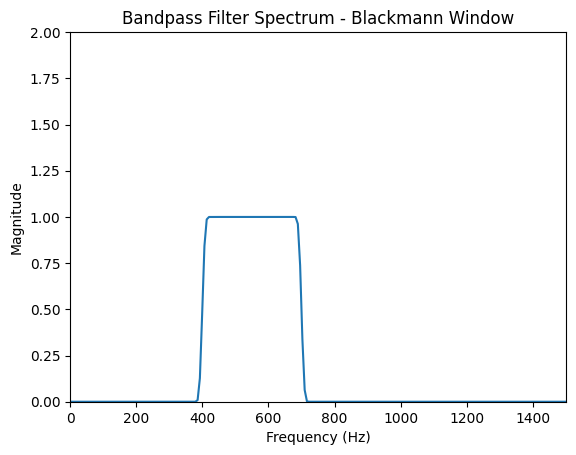

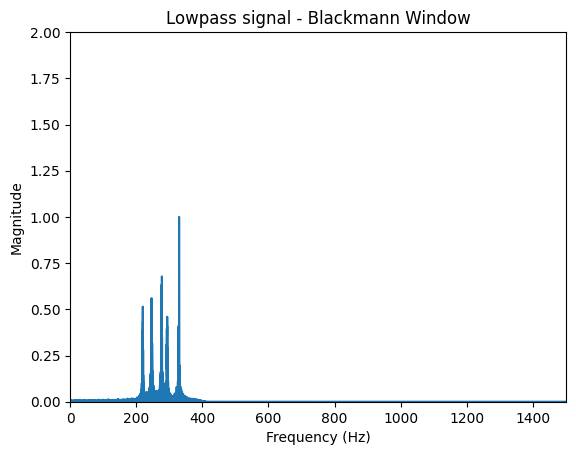

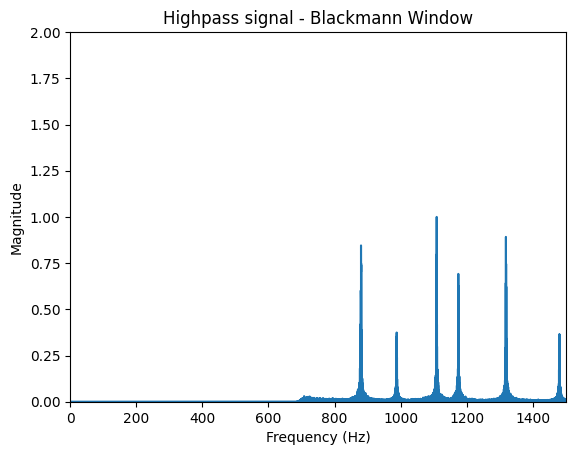

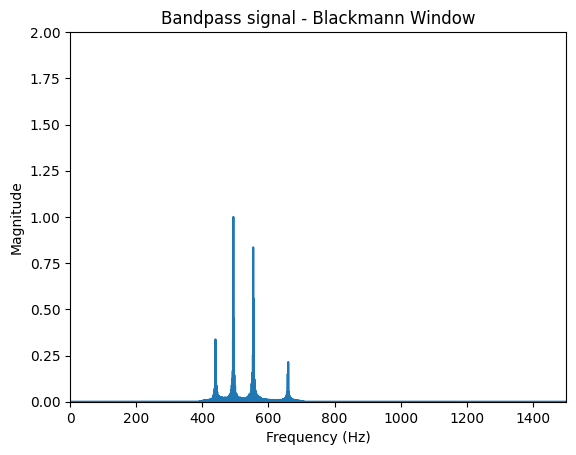

factor, fs, new_fs 22 44100 2000
factor, fs, new_fs 22 44100 2000
factor, fs, new_fs 22 44100 2000


In [81]:
# Read the wav file
fs, data = wavfile.read('HW2_Mix.wav')

# Plot the magnitude spectrum of the input signal
plot_spectrum(data, "Original spectrum", fs, [0, 1500], [0, 2])

fc_low = 400  # Hz
fc_high = 700  # Hz
fc_band = np.array([400, 700])  # Hz
filter_size = 6401

# Generate filter with Blackmann window - Lowpass, Highpass, Bandpass
lowpass_blackmann_filter = filter_generator(fs, fc_low, 'Lowpass', 'Blackmann', filter_size)
highpass_blackmann_filter = filter_generator(fs, fc_high, 'Highpass', 'Blackmann', filter_size)
bandpass_blackmann_filter = filter_generator(fs, fc_band, 'Bandpass', 'Blackmann', filter_size)

# Plot filter shape
plot_filter(lowpass_blackmann_filter, "Lowpass Filter - Blackmann Window")
plot_filter(highpass_blackmann_filter, "Highpass Filter - Blackmann Window")
plot_filter(bandpass_blackmann_filter, "Bandpass Filter - Blackmann Window")

# Plot the magnitude spectrum of different filters
plot_spectrum(lowpass_blackmann_filter, "Lowpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(highpass_blackmann_filter, "Highpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(bandpass_blackmann_filter, "Bandpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])

# Convolve the input signal with different filters
signal_low = convolve(data, lowpass_blackmann_filter, filter_size)
signal_high = convolve(data, highpass_blackmann_filter, filter_size)
signal_band = convolve(data, bandpass_blackmann_filter, filter_size)
plot_spectrum(signal_low, "Lowpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_high, "Highpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_band, "Bandpass signal - Blackmann Window", fs, [0, 1500], [0, 2])

# save audio
wavfile.write(f"Low_pass_{fc_low}.wav", fs, signal_low)
wavfile.write(f"High_pass_{fc_high}.wav", fs, signal_high)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}.wav", fs, signal_band)

# Reduce sample rate
new_fs = 2000
signal_low_ds = down_sampling(signal_low, fs, new_fs)
signal_high_ds = down_sampling(signal_high, fs, new_fs)
signal_band_ds = down_sampling(signal_band, fs, new_fs)

# You can also try setting 'new_fs' as 'fs' to see what happens.
wavfile.write(f"Low_pass_{fc_low}_2khz.wav", new_fs, signal_low_ds)
wavfile.write(f"High_pass_{fc_high}_2khz.wav", new_fs, signal_high_ds)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}_2khz.wav", new_fs, signal_band_ds)

# Generate echo
echo_one , echo_multiple = echo(signal_low, 1, 0.5, fs)
wavfile.write('Echo_one.wav', fs, echo_one)
wavfile.write("Echo_multiple.wav", fs, echo_multiple)

## Report (20%)

Your report should cover the following aspects:
* DCT compression
    * Describe how you implemented the discrete cosine transform. (4%)
      1. 將輸入影像分割成 8x8 的像素區塊。
      2. 對每個區塊應用 DCT 公式，將其從空間域轉換到頻率域。
      3. DCT 公式涉及對區塊中的每個像素進行餘弦函數的加權求和。
      4. 輸出的 DCT 係數表示影像在不同頻率分量上的強度。
    * Why should we convert image from RGB to YCbCr before compressing? (3%)
      1. YCbCr 格式將亮度 (Y) 和色度 (Cb、Cr) 分開表示。由於人眼對亮度變化更敏感，因此可以對色度分量進行更大幅度的壓縮，而不會明顯降低影像品質。
      2. RGB 格式中，三個顏色通道 (R、G、B) 之間存在高度相關性。YCbCr 格式通過將顏色資訊轉換到不同的空間，可以減少資料冗餘，從而提高壓縮效率。
    * Explain how can the quality factor affects the compression result. (3%)
      1. QF 值越低，壓縮率越高，但影像品質也會下降。QF 值越高，壓縮率越低，但影像品質會越好。
      2. QF 值越低，量化表中的值越大，導致量化後的 DCT 係數更粗糙，從而降低影像品質。
* FIR Filter
    * Describe how you implemented the filter and convolutions to separate tha mixed song. And how did you determine the filter size and cut-off frequency. (4%)
      1. 使用 filter_generator 函數產生低通、高通和帶通濾波器。
      2. filter_generator 函數使用 Blackman 窗函數來減少濾波器的旁瓣效應。
      3. 使用 convolve 函數將輸入訊號與濾波器進行卷積。
      4. 卷積運算將濾波器係數與訊號樣本相乘並求和，產生濾波後的輸出訊號。
      5. 在可以接受的時間内盡量提高濾波器尺寸，好把音頻分乾净。接著觀察三首曲子的旋律所對應的頻率，調整截止頻率。
    * Compare the spectrum and shape of the filters. (3%)
      1. 低通濾波器： 頻譜在低頻區域具有較高的增益，在高頻區域具有較低的增益。
      2. 高通濾波器： 頻譜在高頻區域具有較高的增益，在低頻區域具有較低的增益。
      3. 帶通濾波器： 頻譜在特定頻率範圍內具有較高的增益，在其他頻率區域具有較低的增益。
    * Compare the difference between the signals before and after reducing the sampling rates. (3%)
      1. 降采樣后高頻因爲頻率高於采樣率，所以會被嚴重破壞。

